In this blog I'll discuss the [Wukong paper](https://arxiv.org/abs/2403.02545), which aims to introduce scaling laws to recommendation systems. Scaling laws have been instrumental in advancing LLMs, enabling researchers to predict how performance improves as model parameters increase, and providing confidence that continued scaling will yield further gains. However, this has not yet been the case for recommendation systems, which face challenges including a lack of open-source research efforts, limited computational resources, and a wide diversity of architectures. To help address this gap, this paper, primarily authored by researchers at Meta, introduces an architecture and approach designed to establish scaling laws for RecSys.


# Introduction

Recommendation datasets are growing rapidly in both size and complexity. The conventional approach to scaling these models has been to increase the size of embedding tables — essentially giving the model more capacity to memorise individual feature representations. However, this strategy misses a critical element: it fails to capture the interactions between features, and bottlenecks compute around the embedding layer itself.

Existing architectures such as DLRM and DCN lack inherent scaling strategies that allow performance to improve predictably as compute and parameters increase. Wukong aims to address this gap by introducing an architecture built around Factorised Machines, which are designed to capture both individual feature representations and the interactions between them.

# Related Work

A variety of approaches have been proposed to model feature interactions in recommendation systems. Factorization Machines (FMs) were among the first to efficiently capture second-order interactions between features, and have since been extended by architectures such as DeepFM and xDeepFM, which combine FMs with deep neural networks. Models like DLRM use embedding dot products to capture pairwise interactions, while Deep & Cross Network (DCN) introduces explicit cross layers to model higher-order feature combinations.

However, these existing methods face notable limitations. Most architectures are fundamentally constrained to second-order interactions, relying on pairwise dot products or shallow cross layers that struggle to capture the more complex, higher-order relationships present in large-scale datasets. Furthermore, the scaling behaviour of these models remains largely unexplored — unlike in the language modelling domain, where scaling laws have guided the development of increasingly powerful models, recommendation systems lack equivalent research into how performance scales with model size and compute. This gap makes it difficult to predict whether increasing a model's capacity will yield meaningful improvements, and leaves the field without a clear roadmap for scaling.

# Design of Wukong

![](../../assets/wukong_architecture.png)
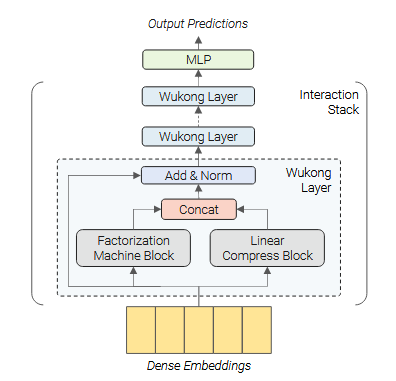

Wukong is designed with two key objectives in mind. First, the architecture must be capable of capturing higher-order feature interactions — moving beyond the pairwise limitations of existing approaches like DLRM and DCN. Second, it must exhibit a clear scaling relationship between model parameters, dataset size, and performance, enabling researchers to predict gains from increased compute in the same way that scaling laws have guided progress in LLMs.

## Embedding Layer

The model uses a global embedding dimension, `d`, shared across all features. Categorical inputs are mapped via embedding table lookups, while dense inputs are transformed by an MLP into `d` dimensions (it's not clear from the paper whether this is done on a per-feature basis or whether all dense features are first concatenated). This results in a series of `n` latent feature representations, represented in PyTorch as tensors of shape `(B, d, n)` where `B` is the batch size. These embeddings are then processed by the Interaction Stack.

An important design choice here is that, unlike architectures such as DCN which flatten all feature embeddings into a single vector of shape `(B, n*d)`, Wukong preserves each embedding as a distinct unit. In PyTorch terms, DCN effectively does `torch.cat(embs, dim=-1)` while Wukong does `torch.stack(embs, dim=-1)`. This means that when the Factorization Machine layers compute interactions, they operate on whole feature vectors rather than individual scalar components — the entire "user age" embedding interacts with the entire "item category" embedding, preserving the semantic structure of each feature throughout the network.

For categorical features, the paper describes a multi-hot lookup scheme: given a multi-hot input, each active dimension triggers an embedding lookup, and the results are aggregated via a pooling operation — usually a simple summation. While some features are naturally single-valued (such as user ID), many categorical features at scale are inherently multi-valued — for instance, the set of topics a user follows, or the IDs of recently viewed content. That said, sum pooling is a notably lossy operation. It discards information about the ordering, relative importance, and nonlinear relationships between the pooled items. More expressive alternatives exist — sequential models like SASRec and BERT4Rec use attention-based pooling — but the computational cost of applying these within every feature becomes prohibitive at Meta's scale, where a single dataset can contain hundreds of features. Wukong's design philosophy places its modelling investment in the interaction stack rather than the embedding layer, betting that stacked FM layers will compensate for the simplicity of the pooling step. Personally, I think this is an area ripe for improvement — particularly for features that are inherently sequential, such as a user's recent viewing history, where a mechanism that can attend to different parts of the sequence and respect ordering would likely capture richer representations than a simple sum.


The paper also briefly describes a scheme for varying embedding capacity based on feature importance. More significant features are allocated multiple embeddings each, all of dimension `d`, effectively increasing their presence in the interaction stack and giving them more surface area for interactions. Less important features are assigned smaller initial embedding dimensions, which are then grouped, concatenated, and projected up to `d` via an MLP. However, this is covered in barely half a paragraph, and the explanation feels underdeveloped. Critical questions — how is feature importance determined? What are the smaller embedding dimensions? How are features grouped? — are left entirely unanswered. Given that these decisions could have a substantial impact on model configuration and performance, this is a notable gap in the paper's exposition.


## Interaction Stack

The interaction stack is the core of Wukong's architecture, and is where feature interactions are modelled. It consists of `l` identical layers stacked in sequence, with each layer capturing progressively higher-order feature interactions. Every layer takes in a tensor of shape `(B, n, d)` — a batch of `n` feature embeddings of dimension `d` — and produces a new tensor of the same shape.

Each layer has two parallel branches: a Factorization Machine Block (FMB) and a Linear Compression Block (LCB). The FMB is responsible for creating new, higher-order interactions between features, while the LCB preserves lower-order interactions by passing through a linearly recombined copy of the input. The outputs of both branches are concatenated along the feature axis, and a residual connection and layer norm are applied to produce the layer's output.

### Factorization Machine Block

The FMB computes pairwise dot products between all input feature embeddings — effectively computing XX^T to produce a `(B, n, n)` interaction matrix. This matrix is then flattened, layer-normalised, and passed through an MLP which projects it back to `n_F` embeddings of dimension `d`. The key insight here is that, because the FMB operates on the *outputs* of the previous layer, it is computing interactions between embeddings that already encode interactions themselves. This is what allows the interaction order to grow exponentially: layer 1 captures up to 2nd-order interactions, layer 2 up to 4th-order, layer 3 up to 8th-order, and in general layer `i` captures up to 2^i-order interactions.

### Linear Compression Block

The LCB is deceptively simple — it applies a single linear transformation along the feature axis, mapping `n` input embeddings to `n_L` output embeddings without introducing any new feature interactions. Its role is essential, however: without it, each layer would only retain the highest-order interactions, discarding all lower orders. By concatenating the LCB's linearly-mixed copy of the input (which already contains orders 1 through 2^(i-1)) with the FMB's output, the full range of interaction orders from 1 through 2^i is preserved at every layer.

### Implementation

In [ ]:
import torch
import torch.nn as nn

class LCB(nn.Module):
    """Linear Compression Block: linearly recombines embeddings without creating new interactions"""
    def __init__(self, n_in, n_L):
        super().__init__()
        # Weight matrix maps n_in embeddings -> n_L embeddings
        # Operates on the feature axis, NOT the embedding dim
        self.W = nn.Linear(n_in, n_L, bias=False)
    
    def forward(self, X):
        # X: (B, n_in, d)
        return self.W(X.transpose(-1, -2)).transpose(-1, -2)  # (B, n_L, d)

class FMB(nn.Module):
    """Factorization Machine Block: computes pairwise interactions then projects back"""
    def __init__(self, n_in, n_F, d):
        super().__init__()
        self.n_F = n_F
        self.d = d
        self.ln = nn.LayerNorm(n_in * n_in)
        self.mlp = nn.Sequential(
            nn.Linear(n_in * n_in, n_F * d),
            nn.ReLU(),
            nn.Linear(n_F * d, n_F * d),
        )
    
    def forward(self, X):
        # X: (B, n_in, d)
        B = X.size(0)
        # FM: pairwise dot products between all feature embeddings
        interaction = X @ X.transpose(-1, -2)  # (B, n_in, n_in) — this is XX^T
        flat = interaction.flatten(1)            # (B, n_in * n_in)
        out = self.mlp(self.ln(flat))            # (B, n_F * d)
        return out.view(B, self.n_F, self.d)     # (B, n_F, d)

class InteractionLayer(nn.Module):
    def __init__(self, n_in, n_F, n_L, d):
        super().__init__()
        self.fmb = FMB(n_in, n_F, d)
        self.lcb = LCB(n_in, n_L)
        self.ln = nn.LayerNorm(d)
        # n_F + n_L must equal n_in for the residual to work
        # (or use a projection if they differ)
        self.residual_proj = nn.Linear(n_in, n_F + n_L, bias=False) if (n_F + n_L) != n_in else nn.Identity()
    
    def forward(self, X):
        # X: (B, n_in, d)
        fmb_out = self.fmb(X)                          # (B, n_F, d)
        lcb_out = self.lcb(X)                           # (B, n_L, d)
        combined = torch.cat([fmb_out, lcb_out], dim=1) # (B, n_F + n_L, d)
        
        # Residual (project if shapes don't match)
        residual = self.residual_proj(X.transpose(-1,-2)).transpose(-1,-2)
        
        return self.ln(combined + residual)              # (B, n_F + n_L, d)

## Optimized FM

The Factorization Machine Block computes pairwise dot products between all feature embeddings — XX^T — which produces an interaction matrix of shape (n, n). This means the computation scales quadratically with the number of features, which quickly becomes prohibitive on real-world datasets at Meta's scale, where a single model may operate over hundreds or even thousands of features.

To address this, Wukong adopts a low-rank approximation of the interaction matrix. The key observation, supported by prior work, is that the pairwise dot product matrix XX^T is often low-rank in practice — when the embedding dimension d is smaller than the number of features n (which is common on large datasets), the interaction matrix has rank at most d, meaning much of the (n, n) matrix is redundant.

The optimisation introduces a learned projection matrix Y of shape (n, k), where k << n, and replaces the full interaction XX^T with the compressed form XX^T Y, which has shape (n, k). This reduces the output from n² interaction terms down to nk — a substantial saving. But the real trick is computational: rather than computing the expensive XX^T first and then multiplying by Y, the authors exploit the associativity of matrix multiplication to reorder the operation as X(X^T Y). Since X^T is (d, n) and Y is (n, k), the inner product X^T Y yields a small (d, k) matrix, which is then multiplied by X at shape (n, d) to produce the final (n, k) result. This avoids ever materialising the full (n, n) interaction matrix, reducing the complexity from O(n²d) to O(nkd).


## Scaling Wukong

Unlike traditional recommendation architectures, which typically scale only by enlarging embedding tables, Wukong offers multiple axes along which the model can grow:

- `l`: the number of layers in the Interaction Stack, which controls the maximum order of feature interactions (up to 2^l).
- `n_F`: the number of embeddings produced by the FMB at each layer, governing the capacity for new interaction terms.
- `n_L`: the number of embeddings produced by the LCB at each layer, controlling how much lower-order information is preserved.
- `k`: the rank of the compressed interaction matrix in the optimised FM, which trades off expressiveness against computational cost.
- MLP width and depth within the FMB, which determine how flexibly the raw interaction terms are recombined.

This multi-dimensional scaling space is one of Wukong's distinguishing features — rather than being limited to a single knob (embedding table size), the architecture can be scaled along several independent axes, each of which affects model capacity in a different way. The paper states that their scaling strategy begins by increasing `l` first, then adjusts the remaining hyperparameters, though the precise protocol — how they decide when to stop scaling depth and begin widening, or how the hyperparameters are jointly tuned — is not clearly described.

# Implementation

The paper provides relatively few details on the training infrastructure, but outlines the key distributed training strategies used. Embedding tables — which account for the majority of parameters in large-scale recommendation models — are sharded across devices using techniques described in the Neo and Neuroshard papers. These approaches optimise how embedding tables are partitioned and placed across GPUs to balance memory usage and communication costs, and are likely similar in spirit to the sharding strategies available in Meta's open-source TorchRec library. The remaining model components — the interaction stack and MLPs — are parallelised using Fully Sharded Data Parallelism (FSDP), which shards model parameters, gradients, and optimiser states across workers and reassembles them on-the-fly during forward and backward passes. Mixed precision training is also employed for computational efficiency, using lower-precision formats (typically FP16 or BF16) for the bulk of computation while maintaining FP32 where numerical stability requires it.

The implementation section is notably thin given the scale of the systems involved. Questions around training convergence, learning rate schedules, batch sizes, and how the distributed strategy interacts with the optimised FM's low-rank projections are left unaddressed.

# Evaluations

The paper evaluates Wukong against six public datasets and one internal Meta dataset, comparing it to existing architectures across both performance and scaling behaviour.

## Public Datasets

Wukong is benchmarked against several commonly used public recommendation datasets, including MovieLens and Criteo, with AUC and Log Loss as the primary evaluation metrics. On these benchmarks, Wukong consistently matches or outperforms baselines such as DLRM and DCN. However, it's worth noting that the choice of metrics here is somewhat narrow — Recall@k and NDCG@k are arguably more standard in recommendation system evaluation, as they measure the quality of ranked lists rather than pointwise prediction accuracy. That said, evaluation in the recommendation systems space is notoriously fragmented, with different papers, benchmarks, and production systems often adopting different metrics and evaluation protocols, making direct comparisons across the literature difficult.

## Internal Dataset

To demonstrate Wukong's scaling properties, the authors evaluate on an internal Meta dataset containing 146 billion samples and 720 features — roughly 37× more samples and 18× more features than Criteo, the largest widely used public benchmark. On this dataset, Wukong exhibits consistent scaling behaviour, with Log Loss decreasing steadily as the number of parameters increases. In contrast, baseline architectures show diminishing or inconsistent returns from additional parameters, reinforcing the paper's central claim that Wukong's architecture is better suited to scaling. That said, the scaling analysis is conducted exclusively through the lens of Log Loss, and it would be valuable to see whether these gains hold under alternative metrics that more directly reflect recommendation quality.

![](../../assets/wukong_scaling.png)

## BARS / FuxiCTR

The paper references the BARS evaluation framework when reporting results on public datasets. From what I can tell, this originated in [this repository](https://github.com/reczoo/BARS) and has since evolved into a broader framework for CTR model training and evaluation called [FuxiCTR](https://github.com/reczoo/FuxiCTR).

Exploring FuxiCTR has been a bit humbling — it covers a great deal of ground that I've been independently working towards in [my own recommendation systems repository](https://github.com/AndrewBoney/rec), and in several areas their implementation is more mature. A few components stand out in particular:

- **[Data preprocessing](https://github.com/reczoo/FuxiCTR/tree/main/fuxictr/preprocess):** A clean and efficient pipeline built on Polars, with well-structured Python throughout. This is an area where I've spent a lot of time reinventing the wheel.
- **[Metrics](https://github.com/reczoo/FuxiCTR/blob/main/fuxictr/metrics.py):** A minimal but effective implementation of standard evaluation metrics — though notably, it doesn't appear to include hit@k-style metrics as far as I can see.
- **[Base model classes](https://github.com/reczoo/FuxiCTR/blob/main/fuxictr/pytorch/models/rank_model.py):** A shared base class used across all models, providing consistent training, evaluation, and logging methods.

That said, I think there's still value in what I'm building independently — in particular, my focus on implementing both retrieval and ranking stages within a unified framework, along with deployment tooling, goes beyond what FuxiCTR currently offers. But for the core training loop and data preparation pipeline, I'm strongly considering adopting parts of their approach rather than continuing to build everything from scratch.

## Ablation

The paper includes two ablation studies that shed light on which components of Wukong matter most.

**Significance of Individual Components.** The authors systematically remove individual components — the FMB, LCB, and residual connections — and measure the impact on model performance. The results are striking: removing the FMB causes a significant degradation, confirming that the factorization-based interaction mechanism is the primary driver of Wukong's effectiveness. In contrast, removing the LCB or the residual connections has only a marginal effect. This raises an interesting question — if these components contribute so little to performance, could they be dropped entirely in favour of a simpler architecture? Doing so would reduce per-layer compute, potentially allowing the savings to be reinvested into additional interaction layers or wider MLPs within the FMB, where the ablation suggests the modelling capacity is most productively spent.

**Impact of Scaling Individual Components.** The second ablation examines the effect of scaling each architectural dimension independently versus scaling them jointly. The results show that combined scaling across all dimensions yields the best performance, as one would hope. Among individual dimensions, increasing the number of interaction layers (`l`) and the MLP width within the FMB have the most significant impact — consistent with the first ablation's finding that the FMB is the most critical component, and with the intuition that depth (which controls the maximum interaction order) is a key lever for this architecture.

# Discussion

The paper concludes with a candid acknowledgement of the computational constraints involved. Despite being conducted at Meta — one of the most resource-rich environments in the industry — the experiments were still limited by available compute. The scaling analysis, while compelling, covers only a portion of the parameter range one might wish to explore, and the authors note that serving large-scale Wukong models in production introduces additional latency and infrastructure challenges that remain open problems. It's a useful reminder that even at the frontier of industrial research, compute is a binding constraint — and that scaling laws are only as credible as the range over which they've been validated.

The authors also outline several directions for future work. These include deeper investigation into the architectural dynamics of Wukong — for instance, understanding which interaction orders contribute most to performance, and whether the architecture can be further optimised by pruning less useful components (a question the ablation results already hint at). They also raise the possibility of generalising the Wukong framework beyond recommendation systems to other domains involving structured feature interactions, though no concrete examples or experiments are offered in this direction.

# Summary

I found this paper very insightful. The core idea — stacking Factorization Machine layers so that interaction order grows exponentially with depth — is elegant and well-motivated, directly addressing the pairwise interaction ceiling that limits architectures like DLRM and DCN. The low-rank FM optimisation is a practical necessity at Meta's scale, and the trick of reordering the matrix multiplication to avoid materialising the full interaction matrix is neat.

There are a few areas I wish the paper went deeper on. The variable-capacity embedding scheme and the scaling protocol (when to add depth versus width) are both underdeveloped, and the ablation results hint at an interesting simplification — if the LCB and residual connections barely matter, could that compute be better spent on more FMB capacity? It's a thread I'd have liked to see pulled on further.

My main takeaway, though, is actually FuxiCTR. I've been looking for a consistent, well-structured framework for recommendation system research for a while now, and have been building towards something similar in my own repository. Discovering FuxiCTR — particularly its preprocessing and shared base model classes — has me reconsidering how much of that infrastructure I should be building from scratch. When I get the time, I'm planning to go back to my own implementation and adopt the best parts of their approach, while continuing to focus on the areas I think my work adds something different — unifying retrieval and ranking within a single framework, along with deployment tooling.